In [3]:
#Get the dataset
!wget https://zenodo.org/record/3587843/files/TACO.zip?download=1

--2021-02-26 16:43:00--  https://zenodo.org/record/3587843/files/TACO.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2719810615 (2.5G) [application/octet-stream]
Saving to: ‘TACO.zip?download=1.1’

TACO.zip?download=1 100%[===================>]   2.53G  5.50MB/s    in 4m 17s  

2021-02-26 16:47:19 (10.1 MB/s) - ‘TACO.zip?download=1.1’ saved [2719810615/2719810615]



In [15]:
#Import packages
import os
import zipfile
import numpy as np
import json
import pandas as pd
from shutil import copy
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import pathlib
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
#Unzip the files ; if load fails, might change from 1 to 1.1 or 1.2 for example
local_zip = 'TACO.zip?download=1.1'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [13]:
#Look at the files in the directory 
print('Current directory:', pathlib.Path().absolute())
print('In the directory:', os.listdir())
print('Within TACO:' , os.listdir('TACO'))
print('Within data:', os.listdir('TACO/data'),'\n')
print('File count per batch:')
for i in range(1,16):
    print('batch_'+str(i)+':',len(os.listdir('TACO/data/batch_'+str(i))))

Current directory: /content
In the directory: ['.config', 'TACO.zip?download=1', 'TACO.zip?download=1.1', 'TACO', '__MACOSX', 'sample_data']
Within TACO: ['download.py', 'LICENSE', 'requirements.txt', 'demo.ipynb', '.ipynb_checkpoints', '.git', '.DS_Store', 'data', 'detector', '.gitignore', 'README.md']
Within data: ['batch_1', 'batch_7', 'batch_10', 'batch_6', 'batch_12', 'batch_5', 'annotations.json', 'batch_11', 'batch_13', 'batch_4', 'batch_3', 'batch_15', 'batch_9', 'batch_8', 'batch_2', '.DS_Store', 'batch_14'] 

File count per batch:
batch_1: 102
batch_2: 93
batch_3: 98
batch_4: 90
batch_5: 113
batch_6: 98
batch_7: 128
batch_8: 101
batch_9: 101
batch_10: 101
batch_11: 102
batch_12: 101
batch_13: 101
batch_14: 101
batch_15: 86


In [28]:
#Read annotations
print('See values in dictionary:')
with open('/content/TACO/data/batch_1/annotations.json') as f:
  data = json.load(f)
for key in data:
  print(key)

See values in dictionary:
info
images
annotations
scene_annotations
licenses
categories
scene_categories


In [26]:
#Image information
df_images = pd.DataFrame(data['images'])
df_images[df_images['file_name']=='000024.jpg']

,id,width,height,file_name,license,flickr_url,coco_url,date_captured,flickr_640_url
28,28,1537,2049,000024.jpg,None,https://farm66.staticflickr.com/65535/46939255...,None,None,https://farm66.staticflickr.com/65535/46939255...


In [6]:
#Category information
df_annotations = pd.DataFrame(data['annotations'])
df_annotations.head(3)

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1071259.5,"[1.0, 457.0, 1429.0, 1519.0]",0
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",99583.5,"[531.0, 292.0, 1006.0, 672.0]",0


In [7]:
#Category information
df_categories = pd.DataFrame(data['categories'])
df_categories.head(3)

,supercategory,id,name
0,Aluminium foil,0,Aluminium foil
1,Battery,1,Battery
2,Blister pack,2,Aluminium blister pack


In [38]:
#Get all images and details in one list
x = range(1,16)
df_all = pd.DataFrame()
for i in x:
    directory = '/content/TACO/data/batch_'+str(i)+'/annotations.json'
    with open(directory) as f:
        data = json.load(f)
    df_images = pd.DataFrame(data['images'])
    df_images['batch'] = 'batch_'+str(i)
    df_images['image_id'] = df_images['id']
    #add a new column for joining with same name
    df_annotations = pd.DataFrame(data['annotations'])
    df_categories = pd.DataFrame(data['categories'])
    df_categories['category_id'] = df_categories['id']
    df_1 = df_images.join(df_annotations,on='image_id',rsuffix='_anno')
    df_2 = df_1.join(df_categories,on='category_id',rsuffix='_cat')
    df_3 = df_2.append(df_images)
    df_all = df_all.append(df_3)

df_all.head(5)

,id,width,height,file_name,license,flickr_url,coco_url,date_captured,flickr_640_url,batch,image_id,id_anno,image_id_anno,category_id,segmentation,area,bbox,iscrowd,supercategory,id_cat,name,category_id_cat
0,0,1537,2049,000006.jpg,None,https://farm66.staticflickr.com/65535/33978196...,None,None,https://farm66.staticflickr.com/65535/33978196...,batch_1,0,1.0,0.0,6.0,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0.0,Bottle,6.0,Glass bottle,6.0
1,1,1537,2049,000008.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...,batch_1,1,2.0,1.0,18.0,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1071259.5,"[1.0, 457.0, 1429.0, 1519.0]",0.0,Carton,18.0,Meal carton,18.0
2,2,1537,2049,000010.jpg,None,https://farm66.staticflickr.com/65535/40888872...,None,None,https://farm66.staticflickr.com/65535/40888872...,batch_1,2,3.0,1.0,14.0,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",99583.5,"[531.0, 292.0, 1006.0, 672.0]",0.0,Carton,14.0,Other carton,14.0
3,3,2049,1537,000019.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...,batch_1,3,4.0,2.0,5.0,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0.0,Bottle,5.0,Clear plastic bottle,5.0
4,4,1537,2049,000026.jpg,None,https://farm66.staticflickr.com/65535/33978199...,None,None,https://farm66.staticflickr.com/65535/33978199...,batch_1,4,5.0,2.0,7.0,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",915.0,"[632.0, 989.0, 44.0, 51.0]",0.0,Bottle cap,7.0,Plastic bottle cap,7.0


In [62]:
#Get shape of information
#notes that one image can have multiple rows if falls into multiple categories
df_all.shape

(3000, 22)

In [60]:
#count ids to split
df_imageurls = df_all['flickr_url'].drop_duplicates()
df_imageurls = df_imageurls.iloc[np.random.permutation(len(df_imageurls))]
df_imageurls_test = np.array(df_imageurls[0:600])
df_imageurls_train = np.array(df_imageurls[600:])

#df_all['supercategory'] = df_all['supercategory'].fillna('unknown')

print('Testing images:',len(df_imageurls_test))
df_all_test = df_all[df_all['flickr_url'].isin(df_imageurls_test)]
print('Rows and columns:',df_all_test.shape)
print('Validate unique images within file:',df_all_test['flickr_url'].nunique())

print('\nTraining images:',len(df_imageurls_train))
df_all_train = df_all[df_all['flickr_url'].isin(df_imageurls_train)]
print('Rows and columns:',df_all_train.shape)
print('Validate unique images within file:',df_all_train['flickr_url'].nunique())

Testing images: 600
Rows and columns: (1200, 22)
Validate unique images within file: 600

Training images: 900
Rows and columns: (1800, 22)
Validate unique images within file: 900


In [61]:
#make sure the count of categories matches per grouping! otheriwse reshuffle 
#in above cell
#create folders
df_all_train = df_all_train[df_all_train['supercategory']!='unknown']
df_all_test = df_all_test[df_all_test['supercategory']!='unknown']

print(df_all_train['supercategory'].nunique())
print(df_all_train['supercategory'].unique())
print(df_all_test['supercategory'].nunique())
print(df_all_test['supercategory'].unique())

#list of super categories cleaned
#use smaller list since test and train have to match
x = df_all_test['supercategory'].unique()
lc= np.array(x)

24
['Carton' 'Bottle' 'Bottle cap' 'Can' 'Pop tab' 'Cup'
 'Plastic bag & wrapper' 'Styrofoam piece' 'Other plastic'
 'Plastic container' 'Paper' 'Straw' 'Unlabeled litter' 'Food waste'
 'Scrap metal' 'Lid' 'Glass jar' 'Aluminium foil' 'Rope & strings'
 'Paper bag' 'Plastic utensils' 'Broken glass' 'Cigarette'
 'Squeezable tube']
24
['Bottle' 'Carton' 'Bottle cap' 'Can' 'Pop tab' 'Plastic container'
 'Paper' 'Plastic bag & wrapper' 'Cup' 'Lid' 'Straw' 'Unlabeled litter'
 'Plastic utensils' 'Other plastic' 'Aluminium foil' 'Rope & strings'
 'Styrofoam piece' 'Squeezable tube' 'Scrap metal' 'Broken glass'
 'Cigarette' 'Shoe' 'Plastic glooves' 'Paper bag']


In [63]:
#create directory structure
path = '/content/trashpred/'
if os.path.isdir(path) == False:
  os.mkdir(path)
  print('base folder created')
else:
  print('base folder exists')

path_test = '/content/trashpred/test/'
if os.path.isdir(path_test) == False:
  os.mkdir(path_test)
  print('test folder created')
else:
  print('test folder exists')

path_train = '/content/trashpred/train/'
if os.path.isdir(path_train) == False:
  os.mkdir(path_train)
  print('train folder created')
else:
  print('train folder exists')

base folder created
test folder created
train folder created


In [64]:
#make folder names
for i in lc:
  pathname_test = '/content/trashpred/test/'+i
  pathname_train = '/content/trashpred/train/'+i
  if os.path.isdir(pathname_train) == False:
    os.mkdir(pathname_train) 
  else:
    print(pathname_train+' exists.')
  if os.path.isdir(pathname_test) == False:
    os.mkdir(pathname_test)
  else:
    print(pathname_test+' exists.')

In [66]:
range_batches = range(1,16)
def move_images(df,src,dest,splittype):
  for i in range_batches:
    b = 'batch_'+str(i)
    b_loc = b+'/'
    df_batch = df[df['batch']==b]
    for cat in lc:
      df_sel = df_batch[df_batch['supercategory']==cat]
      cat_loc = cat+'/'
      image_list = np.array(df_sel['file_name'].unique())
      for image in image_list:
        copy(os.path.join(src,b_loc,image), os.path.join(dest,splittype,cat_loc,image))
        #print(image + 'in' + b + 'moved.')

In [67]:
dest = '/content/trashpred/'
src = '/content/TACO/data/'
train = 'train/'
test = 'test/'

move_images(df_all_test,src,dest,test)
move_images(df_all_train,src,dest,train)

In [68]:
#Look at the files in the directory of the new structure
print('In the directory:', os.listdir('/content/trashpred'))
print('Within train:' , os.listdir('/content/trashpred/train'))
print('Within test: ' , os.listdir('/content/trashpred/test'))
print('Within a category:', os.listdir('/content/trashpred/test/Bottle'))

In the directory: ['test', 'train']
Within train: ['Aluminium foil', 'Squeezable tube', 'Paper bag', 'Plastic utensils', 'Carton', 'Other plastic', 'Lid', 'Bottle', 'Plastic container', 'Broken glass', 'Plastic bag & wrapper', 'Can', 'Cup', 'Paper', 'Rope & strings', 'Plastic glooves', 'Unlabeled litter', 'Bottle cap', 'Straw', 'Styrofoam piece', 'Cigarette', 'Scrap metal', 'Pop tab', 'Shoe']
Within test:  ['Aluminium foil', 'Squeezable tube', 'Paper bag', 'Plastic utensils', 'Carton', 'Other plastic', 'Lid', 'Bottle', 'Plastic container', 'Broken glass', 'Plastic bag & wrapper', 'Can', 'Cup', 'Paper', 'Rope & strings', 'Plastic glooves', 'Unlabeled litter', 'Bottle cap', 'Straw', 'Styrofoam piece', 'Cigarette', 'Scrap metal', 'Pop tab', 'Shoe']
Within a category: ['000038.jpg', 'IMG_5055.JPG', '000070.JPG', '000034.JPG', '000022.jpg', '000084.jpg', '000006.JPG', '000077.jpg', '000060.JPG', '000035.jpg', '000114.JPG', '000024.JPG', '000043.JPG', 'IMG_4998.JPG', '000018.jpg', '000055.JP

/content/trashpred/train/Bottle/000039.jpg


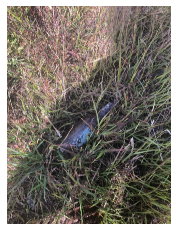

In [73]:
#check if works
loc = '/content/trashpred/train/Bottle/'
img = loc+random.choice(os.listdir(loc)) 
print(img)
image = cv2.imread(img)
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()